In [1]:
from __future__ import annotations

import json
import joblib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)

In [2]:
# функция для сохранения файлов формата json
def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)


In [3]:
df = pd.read_csv('S06-hw-dataset-02.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0


В датасете все числовые столбцы,пропуски отсутвуют.

In [4]:
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,9000.500000,-0.418555,0.614251,0.004559,0.059000,0.405086,0.012123,-0.283473,-0.266880,0.255107,...,-0.139825,0.108568,0.007238,0.000904,-0.716862,-0.274520,0.344991,1.517339,2.576221e+01,0.262611
std,5196.296758,2.178005,3.926778,1.000134,5.713672,2.497581,0.987226,2.193891,2.081431,2.225776,...,2.148834,2.234315,0.997861,1.002115,3.913704,2.482890,4.927315,10.630850,5.423748e+01,0.440065
min,1.000000,-10.014698,-15.510323,-4.031762,-23.663256,-12.289308,-3.741536,-9.591425,-8.293319,-13.655742,...,-8.171469,-9.214171,-3.937091,-3.963063,-19.389908,-10.031559,-20.768452,-107.788145,1.895059e-07,0.000000
25%,4500.750000,-1.866134,-2.048192,-0.673127,-3.544964,-1.153000,-0.653090,-1.743214,-1.688121,-1.177480,...,-1.589638,-1.369266,-0.663023,-0.684164,-3.286842,-1.897893,-2.752685,-2.018750,1.226029e+00,0.000000
50%,9000.500000,-0.465100,0.600291,0.003581,0.072826,0.485625,0.018765,-0.251263,-0.302463,0.350739,...,-0.204785,0.158715,0.001912,-0.003157,-0.618472,-0.339901,0.573153,0.318011,6.581865e+00,0.000000
75%,13500.250000,0.966393,3.229850,0.671390,3.689490,2.075739,0.689304,1.195481,1.109589,1.764113,...,1.254595,1.600671,0.677296,0.676558,1.948803,1.314163,3.649794,4.212111,2.576847e+01,1.000000
max,18000.000000,9.589975,15.417329,3.817025,26.815691,10.665184,3.528280,7.794627,8.892834,8.699629,...,9.290667,8.794320,4.341030,3.781380,14.065595,10.639974,20.226291,94.891804,1.103449e+03,1.000000


In [5]:
df['target'].value_counts(normalize=True)

target
0    0.737389
1    0.262611
Name: proportion, dtype: float64

Бинарные значения распеределены неравномерно, "0" значительно преобладает.

In [6]:
# Подготовка признаков и таргета
X = df[df.columns[1:37].tolist()] # признаки(без client_id).
y = df['target'] # таргет
fn = df.columns[1:38].tolist()
print(f"Признаки: {fn}")
print(f"Целевая переменная: {'target'}")

Признаки: ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'x_int_1', 'x_int_2']
Целевая переменная: target


In [7]:
# Разделение данных на обучающую и тестовую выборки:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42) # Тестовая выборка

random_state фиксирует последовательность случаных чисел, чтобы результат не менялся при каждом запуске;stratify сохраняет распределение классов в обучающей и тестовой выборках,чтобы один класс сильно не преодалевал над другим(как в нашем случае).

In [8]:
# Бейзлайн-модель
baseline = DummyClassifier(strategy="most_frequent", random_state=42)
baseline.fit(X_train, y_train) # Обучение на temp
y_pred_baseline = baseline.predict(X_test) # Оценка  для accuracy метрики
y_proba_baseline = baseline.predict_proba(X_test)[:, 1] # Оценка  для ROC-AUC
print("Accuracy :", accuracy_score(y_test, y_pred_baseline))
print("F1 :", f1_score(y_test, y_pred_baseline))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_baseline))

Accuracy : 0.7375
F1 : 0.0
ROC-AUC  : 0.5


In [15]:
# Создаем словарь с результатами всех метрик
results = {
    "metadata": {
        "experiment_name": "HW06",
        "created_at": "19-01-2026",
        "author": "Меликов Фазиль"
    },
    "test_metrics_for_models": {  
        "baseline": {
        },
        "logistic_regression": {
        },
        "tree_reg": {
        },
        "RandomForest":{
        },
        "HistGradientBoosting":{
        },
        "Stacking":{
        }
    }
}

save_json(results, Path("artifacts/metrics_test.json"))

In [18]:
# Обновляем словарь с результатами всех метрик
json_path = Path("artifacts/metrics_test.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)
existing_results["test_metrics_for_models"]["baseline"] = {
            "Accuracy": accuracy_score(y_test, y_pred_baseline),
            "F1": f1_score(y_test, y_pred_baseline),
            "ROC-AUC": roc_auc_score(y_test, y_proba_baseline)
}
save_json(existing_results, json_path)

In [19]:
# Построение Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=10000,C=1000))
])
#Обучение Pipeline
pipe.fit(X_train, y_train)

# Оцениваем на test
y_test_pred = pipe.predict(X_test)
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print("Качество на test")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("F1 :", f1_score(y_test, y_test_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))

# Обновляем словарь с результатами всех метрик
json_path = Path("artifacts/metrics_test.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)
existing_results["test_metrics_for_models"]["logistic_regression"] = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "F1": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_proba)

}
save_json(existing_results, json_path)

Качество на test
Accuracy : 0.8088888888888889
F1 : 0.544973544973545
ROC-AUC  : 0.791725704720055


In [14]:
# Подбор параметра регуляризации C для pipe
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0,1000.0,10000.0,100000.0],
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)
print("Лучший параметр :", grid_search.best_params_)

# Создаем словарь с результатами подобранных параметров
best_parametrs = {
    "LogisticRegression": {
            "best_params": grid_search.best_params_,
            "best_cv_roc_auc": float(grid_search.best_score_)
        
    }
}

save_json(best_parametrs, Path("artifacts/search_summaries.json"))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучший параметр : {'logreg__C': 1000.0}


In [21]:
# Построение дерева решений
tree_reg = DecisionTreeClassifier(
    min_samples_leaf=40,
    random_state=42
)
tree_reg.fit(X_train, y_train)
y_test_pred = tree_reg.predict(X_test)
y_test_proba = tree_reg.predict_proba(X_test)[:, 1]

print("Качество на test")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("F1 :", f1_score(y_test, y_test_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))

# Обновляем словарь с результатами всех метрик
json_path = Path("artifacts/metrics_test.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)
existing_results["test_metrics_for_models"]["tree_reg"] = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "F1": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_proba)

}
save_json(existing_results, json_path)

Качество на test
Accuracy : 0.8341666666666666
F1 : 0.6506729081334114
ROC-AUC  : 0.8427692583624786


In [17]:
# Подбор параметров для tree_reg (контроль сложности)
dt_grid = {
    "max_depth": [None, 3, 5, 8,11,14,17,20,23,26,29],
    "min_samples_leaf": [1, 5, 10, 20,30,40,50,60,70],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01],
}

grid_search = GridSearchCV(
    estimator=tree_reg,
    param_grid=dt_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)
print("Лучший параметр :", grid_search.best_params_)

# Обновляем словарь с результатами всех подобранных параметров
json_path = Path("artifacts/search_summaries.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)
existing_results["tree_reg"] = {
            "best_params": grid_search.best_params_,
            "best_cv_roc_auc": float(grid_search.best_score_)
        
    
}
save_json(existing_results, json_path)

Fitting 5 folds for each of 396 candidates, totalling 1980 fits
Лучший параметр : {'ccp_alpha': 0.0, 'max_depth': None, 'min_samples_leaf': 40}


In [23]:
# Создаем модель случайного леса 
rf = RandomForestClassifier(
    n_estimators=600,
    random_state=42,
    min_samples_leaf = 1,
    n_jobs=-1,
    oob_score=False
)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]

print("Качество на test")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("F1 :", f1_score(y_test, y_test_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))

# Обновляем словарь с результатами всех метрик
json_path = Path("artifacts/metrics_test.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)
existing_results["test_metrics_for_models"]["RandomForest"] = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "F1": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_proba)

}
save_json(existing_results, json_path)

Качество на test
Accuracy : 0.8927777777777778
F1 : 0.7623152709359606
ROC-AUC  : 0.9294122101655058


In [19]:
# Подбор параметров для rf
rf_grid = {
    "min_samples_leaf": [1, 5, 10],
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)
print("Лучший параметр :", grid_search.best_params_)

# Обновляем словарь с результатами всех подобранных параметров
json_path = Path("artifacts/search_summaries.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)
existing_results["RandomForest"] = {
            "best_params": grid_search.best_params_,
            "best_cv_roc_auc": float(grid_search.best_score_)
}
save_json(existing_results, json_path)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Лучший параметр : {'min_samples_leaf': 1}


In [26]:
# Создаем модель градиентного бустинга (используюущую гистрограммы для ускорения работы)
hgb = HistGradientBoostingClassifier(random_state=42,
                                     max_depth=6,
                                     learning_rate=0.15)
hgb.fit(X_train, y_train)
y_test_pred = hgb.predict(X_test)
y_test_proba = hgb.predict_proba(X_test)[:, 1]

RANDOM = [42,56,64,78,89]

    
print("Качество на test")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("F1 :", f1_score(y_test, y_test_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))
print("confusion_matrix:")
print(confusion_matrix(y_test, y_test_pred))
print()
# Обновляем словарь с результатами всех метрик
json_path = Path("artifacts/metrics_test.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)
existing_results["test_metrics_for_models"]["HistGradientBoosting"] = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "F1": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_proba)

}
save_json(existing_results, json_path)

Качество на test
Accuracy : 0.9136111111111112
F1 : 0.8217765042979943
ROC-AUC  : 0.9294213772556523
confusion_matrix:
[[2572   83]
 [ 228  717]]



In [21]:
# Подбор параметров для hgb
hgb_grid = {
    "max_depth": [1, 3, 6],
    "learning_rate":[0.05,0.01,0.15,0.2,0.25,0.3]
}

grid_search = GridSearchCV(
    estimator=hgb,
    param_grid=hgb_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)
print("Лучший параметр :", grid_search.best_params_)


# Обновляем словарь с результатами всех подобранных параметров
json_path = Path("artifacts/search_summaries.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)
existing_results["HistGradientBoosting"] = {
            "best_params": grid_search.best_params_,
            "best_cv_roc_auc": float(grid_search.best_score_)
}
save_json(existing_results, json_path)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучший параметр : {'learning_rate': 0.15, 'max_depth': 6}


In [27]:
# Создаем модель стэкинга по трем различным моделям с резултирующей моделью ввиде логистической регерессии
final_est = LogisticRegression(max_iter=2000)

stack = StackingClassifier(
    estimators=[
    ("pipe", Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=10000,C=1000))
])),
    ("rf", RandomForestClassifier(
    n_estimators=600,
    random_state=42,
    min_samples_leaf = 1,
    n_jobs=-1,
    oob_score=False
)),
    ("hgb", HistGradientBoostingClassifier(random_state=42,
                                     max_depth=6,
                                     learning_rate=0.15)),
],
    final_estimator=final_est,
    cv=5,
    n_jobs=-1,
    passthrough=False 
)
stack.fit(X_train, y_train)
y_test_pred = stack.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]

print("Качество на test")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("F1 :", f1_score(y_test, y_test_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))

# Обновляем словарь с результатами всех метрик 
json_path = Path("artifacts/metrics_test.json")
with json_path.open("r", encoding="utf-8") as f:
    existing_results = json.load(f)
existing_results["test_metrics_for_models"]["Stacking"] = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "F1": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_proba)
    
}
save_json(existing_results, json_path)

Качество на test
Accuracy : 0.9180555555555555
F1 : 0.8358375069560379
ROC-AUC  : 0.9294122101655058


In [35]:
# Поиск лучшей модели по метрике ROC-AUC, используя наш json файл с результатами всех метрик для каждой модели
json_path = Path("artifacts/metrics_test.json")
with json_path.open("r", encoding="utf-8") as f:
    data = json.load(f)

best_model = None
best_roc_auc = -1

for model_name, metrics in data["test_metrics_for_models"].items():
    roc_auc = metrics["ROC-AUC"]  
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = model_name

print(f"Лучшая модель по ROC-AUC: {best_model}")
print(f"ROC-AUC: {best_roc_auc:.4f}")


Лучшая модель по ROC-AUC: HistGradientBoosting
ROC-AUC: 0.9294


In [25]:
# Сохранение лучшей модели в файл формата joblib
model_path = Path("artifacts/best_model.joblib")
joblib.dump(hgb, model_path)

['artifacts\\best_model.joblib']

In [31]:
# Создание словаря с мета-данными лучшей модели
model_path = Path("artifacts/best_model_meta.json")
meta = {
    "best_model_name": "HistGradientBoosting",
    "selection_criterion": "ROC-AUC",
    "best_model_test_metrics": {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "F1": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_proba)
    }
}
save_json(meta, model_path)

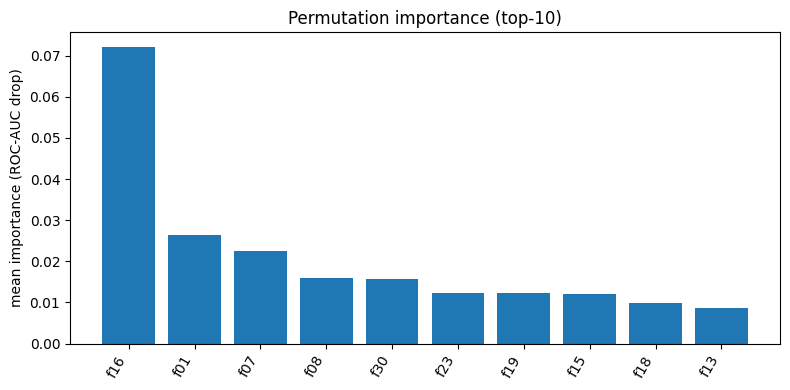

In [35]:
# Интерпретация для hgb (лучшая модель по метрике ROC-AUC)

perm = permutation_importance(
    hgb, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc"
)

importances = perm.importances_mean

# Сортируем признаки по важности (убывание) и возьмём top-10 для наглядного графика.
idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), [fn[i] for i in idx], rotation=60, ha="right")
plt.ylabel("mean importance (ROC-AUC drop)")
plt.title("Permutation importance (top-10)")
plt.tight_layout()
plt.savefig("artifacts/figures/importance_for_best_model.png", dpi=100,bbox_inches='tight')
plt.show()

f16 - самый важный признак в данном датасете.

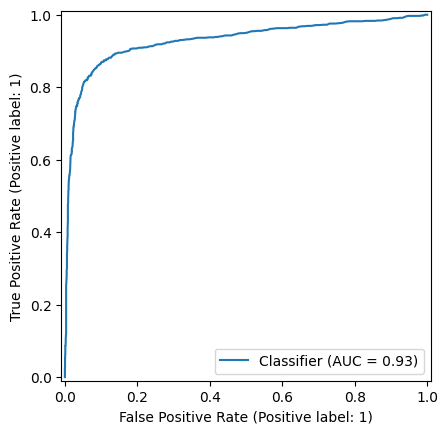

In [36]:
#Построение ROC-кривой для лучшей модели по метрике ROC-AUC:
RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba,
) 
plt.savefig("artifacts/figures/ROC-кривая_for_best_model.png", dpi=100,bbox_inches='tight')